# Creation of Real Test Dataset for MCXcor
This notebooks can be used to recreate the test data set of real data used for testing the `MCXcorStacking` module.  It creates a pickle file of a `TimeSeriesEnsemble` of a subset of data recorded from a large Japanese earthquake in 2011.   That event is one selected from the Earthscope 2024 MsPASS short course data set.  I (Pavlis) selected that event because it had a simple P coda that should be easily handled by the coda duration algorithm used to set the correlation window length by functions in that module.  

This notebook is aimed to make recreating this data set possible without storage of the original, raw waveforms from Earthscope.   It does that by depending on web services to extract data from the IRIS data center.   If that entity disappears or moves the access information will need to be modified.  For the time being the idea is you should be able to run this notebook and create the final pickle file called 'MCXcor_testdata.pickle' used as inputs to the pytest functions for testing the `MCXcorStacking` module.

The comments and markdown boxes are fairly cryptic as this notebook is more for documentation than use.   I can think of only two reasons why this would ever need to be rerun:
1.  We made a major change to the definitions of the MsPASS data objects and pickle.load fails on the file this notebook creates.
2.  Some new feature was added to the MCXcorStacking module that required a change to the data to use for the testing.

Gary Pavlis
Sept. 8, 2024

In [1]:
import mspasspy.client as msc

dbclient = msc.Client(database_name="MCXcorTesting")
db = dbclient.get_database()

First fetch one event from Japan with web services.  This was one event from the tutorial dataset of Earthscope2024.  It was chosen using background in a related notebook which may or may not be preserved called "MCXCor_dataset_workbook.ipynb".   

In [2]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

client = Client("IRIS")
otime_utc = UTCDateTime("2011-10-23T10:41:22.01Z")
starttime = otime_utc - 100.0
endtime = otime_utc + 100.0
lat0 = 38.3
lon0 = 142.5
minmag = 7.0

cat = client.get_events(starttime=starttime, endtime=endtime, minmagnitude=minmag)
# this is a weird incantation suggested by obspy to print a summeary of all the events
print(cat.__str__(print_all=True))

1 Event(s) in Catalog:
2011-10-23T10:41:22.010000Z | +38.729,  +43.447 | 7.1  MW


In [3]:
db.save_catalog(cat)
n = db.source.count_documents({})
print("Number of source documents = ", n)

Number of source documents =  1


Now fetch TA data with web services.  This is a variant of the data_retrieval_mspass2024 notebook found in Earthscope2024.

In [4]:
import os
import time
from obspy.clients.fdsn import RoutingClient

client = RoutingClient("iris-federator")

t0 = time.time()
outdir = "./wftesting"
# obpsy's writer does not create a directory if it doesn't exist
# this standard incantation does that
wfdir_exists = os.path.exists(outdir)
if not wfdir_exists:
    os.makedirs(outdir)
    print("Output directory = ", outdir, " did not exists and was created")
start_offset = 300.0
end_offset = 45 * 60.0
i = 0
doc = db.source.find_one()  # there is only one for this case so using find_one
origin_time = doc["time"]
print("Starting to retrieve data for event with origin time=", UTCDateTime(origin_time))
stime = origin_time + start_offset
etime = origin_time + end_offset
strm = client.get_waveforms(
    starttime=UTCDateTime(stime),
    endtime=UTCDateTime(etime),
    network="TA",
    channel="BH?",
    location="*",
)
fname = outdir + "/testdata.msd"
print("writing miniseed format data to file=", fname)
strm.write(fname, format="MSEED")

Output directory =  ./wftesting  did not exists and was created
Starting to retrieve data for event with origin time= 2011-10-23T10:41:22.010000Z
writing miniseed format data to file= ./wftesting/testdata.msd


/opt/conda/lib/python3.10/site-packages/obspy/io/mseed/core.py:826: UserWarning: File will be written with more than one different record lengths.
This might have a negative influence on the compatibility with other programs.
  warnings.warn(msg % 'record lengths')


In [5]:
ret = db.index_mseed_file("testdata.msd", dir=outdir)
print(ret)

None


Now we need to retrieve channel Metadata that we need to set predicted P wave arrival times.  This is copied from Earthscope2024 and is gross overkill for the volume of station data retrieved.  The operation is not time consuming, however, so we'll just get everything to be sure.

In [6]:
ts = UTCDateTime("2010-01-01T00:00:00.0")
starttime = ts
te = UTCDateTime("2013-01-01T00:00:00.0")
inv = client.get_stations(
    network="TA",
    starttime=starttime,
    endtime=endtime,
    format="xml",
    channel="BH?",
    level="response",
)
net = inv.networks
x = net[0]
sta = x.stations
print("Number of stations retrieved=", len(sta))
ret = db.save_inventory(inv)
print("save_inventory returned value=", ret)

Number of stations retrieved= 823
Database.save_inventory processing summary:
Number of site records processed= 825
number of site records saved= 825
number of channel records processed= 2664
number of channel records saved= 2652
save_inventory returned value= (825, 2652, 825, 2664)


In [7]:
from mspasspy.db.normalize import normalize_mseed

ret = normalize_mseed(db)
print("Number of documents processed in wf_miniseed=", ret[0])
print("Number of documents updated with channel cross reference id=", ret[1])
print("Number of documents updated with site cross reference id=", ret[2])

Number of documents processed in wf_miniseed= 1323
Number of documents updated with channel cross reference id= 1323
Number of documents updated with site cross reference id= 1323


In [8]:
srcdoc = db.source.find_one()
srcid = srcdoc["_id"]
db.wf_miniseed.update_many({}, {"$set": {"source_id": srcid}})

UpdateResult({'n': 1323, 'nModified': 1323, 'ok': 1.0, 'updatedExisting': True}, acknowledged=True)

Verification that normalization seems to have worked - make sure "source_id" and "channel_id" are defined.

In [9]:
from bson import json_util

doc = db.wf_miniseed.find_one()
print(json_util.dumps(doc, indent=2))

{
  "_id": {
    "$oid": "66debfb4fb6995866f53fc8b"
  },
  "sta": "034A",
  "net": "TA",
  "chan": "BHE",
  "sampling_rate": 40.0,
  "delta": 0.025,
  "starttime": 1319366782.0,
  "last_packet_time": 1319369116.2,
  "foff": 0,
  "nbytes": 81920,
  "npts": 96001,
  "endtime": 1319369182.0,
  "storage_mode": "file",
  "format": "mseed",
  "dir": "/home/wftesting",
  "dfile": "testdata.msd",
  "time_standard": "UTC",
  "channel_endtime": 1321549500.0,
  "channel_hang": 89.1,
  "channel_id": {
    "$oid": "66debfcafb6995866f5401b6"
  },
  "channel_starttime": 1262908800.0,
  "channel_vang": 90.0,
  "site_endtime": 1321574399.0,
  "site_id": {
    "$oid": "66debfcafb6995866f5401b6"
  },
  "site_starttime": 1262908800.0,
  "source_id": {
    "$oid": "66debd9efb6995866f53fc8a"
  }
}


Copied from Earthscope2024 Session1 notebook.

In [10]:
from mspasspy.algorithms.window import WindowData
from mspasspy.algorithms.signals import detrend
from mspasspy.algorithms.basic import ator
from mspasspy.ccore.algorithms.basic import TimeWindow
from mspasspy.ccore.utility import ErrorSeverity
from mspasspy.db.normalize import normalize, ObjectIdMatcher, OriginTimeMatcher
from mspasspy.algorithms.window import WindowData
from mspasspy.algorithms.resample import (
    ScipyResampler,
    ScipyDecimator,
    resample,
)
from obspy.geodetics import gps2dist_azimuth, kilometers2degrees
from obspy.taup import TauPyModel
import time


def set_PStime(d, Ptimekey="Ptime", Stimekey="Stime", model=None):
    """
    Function to calculate P and S wave arrival time and set times
    as the header (Metadata) fields defined by Ptimekey and Stimekey.
    Tries to handle some complexities of the travel time calculator
    returns when one or both P and S aren't calculatable.  That is
    the norm in or at the edge of the core shadow.

    :param d:  input TimeSeries datum.  Assumes datum's Metadata
      contains stock source and channel attributes.
    :param Ptimekey:  key used to define the header attribute that
      will contain the computed P time.  Default "Ptime".
    :param model:  instance of obspy TauPyModel travel time engine.
      Default is None.   That mode is slow as an new engine will be
      constructed on each call to the function.  Normal use should
      pass an instance for greater efficiency.
    """
    if d.live:
        if model is None:
            model = TauPyModel(model="iasp91")
        # extract required source attributes
        srclat = d["source_lat"]
        srclon = d["source_lon"]
        srcz = d["source_depth"]
        srct = d["source_time"]
        # extract required channel attributes
        stalat = d["channel_lat"]
        stalon = d["channel_lon"]
        staelev = d["channel_elev"]
        # set up and run travel time calculator
        georesult = gps2dist_azimuth(srclat, srclon, stalat, stalon)
        # obspy's function we just called returns distance in m in element 0 of a tuple
        # their travel time calculator it is degrees so we need this conversion
        dist = kilometers2degrees(georesult[0] / 1000.0)
        arrivals = model.get_travel_times(
            source_depth_in_km=srcz, distance_in_degree=dist, phase_list=["P", "S"]
        )
        # always post this for as it is not cheap to compute
        # WARNING:  don't use common abbrevation delta - collides with data dt
        d["epicentral_distance"] = dist
        # these are CSS3.0 shorthands s - station e - event
        esaz = georesult[1]
        seaz = georesult[2]
        # css3.0 names esax = event to source azimuth; seaz = source to event azimuth
        d["esaz"] = esaz
        d["seaz"] = seaz
        # get_travel_times returns an empty list if a P time cannot be
        # calculated.  We trap that condition and kill the output
        # with an error message
        if len(arrivals) == 2:
            Ptime = srct + arrivals[0].time
            rayp = arrivals[0].ray_param
            Stime = srct + arrivals[1].time
            rayp_S = arrivals[1].ray_param
            d.put(Ptimekey, Ptime)
            d.put(Stimekey, Stime)
            # These keys are not passed as arguments but could be - a choice
            # Ray parameter is needed for free surface transformation operator
            # note tau p calculator in obspy returns p=R sin(theta)/V_0
            d.put("rayp_P", rayp)
            d.put("rayp_S", rayp_S)
        elif len(arrivals) == 1:
            if arrivals[0].name == "P":
                Ptime = srct + arrivals[0].time
                rayp = arrivals[0].ray_param
                d.put(Ptimekey, Ptime)
                d.put("rayp_P", rayp)
            else:
                # Not sure we can assume name is S
                if arrivals[0].name == "S":
                    Stime = srct + arrivals[0].time
                    rayp_S = arrivals[0].ray_param
                    d.put(Stimekey, Stime)
                    d.put("rayp_S", rayp_S)
                else:
                    message = (
                        "Unexpected single phase name returned by taup calculator\n"
                    )
                    message += "Expected phase name S but got " + arrivals[0].name
                    d.elog.log_error("set_PStime", message, ErrorSeverity.Invalid)
                    d.kill()

    # Note python indents mean if an ensemble is marked dead this function just silenetly returns
    # what it received doing nothing - correct mspass model
    return d


def cut_Pwindow(d, stime=-100.0, etime=500.0):
    """
    Window datum relative to P time window.  Time
    interval extracted is Ptime+stime to Ptime+etime.
    Uses ator,rtoa feature of MsPASS.
    """
    if d.live:
        if "Ptime" in d:
            ptime = d["Ptime"]
            d.ator(ptime)
            d = WindowData(d, stime, etime)
            d.rtoa()
    return d

In [11]:
# extra code inserted as variant of Session1 - need to create the normalizer objects.
chan_matcher = ObjectIdMatcher(db)
source_matcher = ObjectIdMatcher(
    db,
    collection="source",
    attributes_to_load=["lat", "lon", "depth", "time", "magnitude"],
)

In [12]:
from obspy.taup import TauPyModel
from mspasspy.algorithms.signals import filter, detrend

ttmodel = TauPyModel(model="iasp91")
stime = -100.0
etime = 500.0

t0 = time.time()
nlive = 0
ndead = 0
cursor = db.wf_miniseed.find({})
for doc in cursor:
    # the normalize matchers in this read were defined in the normalize section of this
    # notebook.  Could cause problems if this box is run out of order
    d = db.read_data(
        doc, collection="wf_miniseed", normalize=[chan_matcher, source_matcher]
    )
    d = detrend(d, type="constant")
    d = filter(d, "bandpass", freqmin=0.01, freqmax=2.0, zerophase=False)
    # this function will run faster if passed an instance the TauP calculator (ttmodel)
    # If left as the default an instance is instantiated on each call to the function which is very inefficient.
    d = set_PStime(d, model=ttmodel)
    d = cut_Pwindow(d, stime, etime)
    if d.live:
        nlive += 1
    else:
        ndead += 1
    db.save_data(d, collection="wf_TimeSeries", data_tag="serial_preprocessed")
t = time.time()
print("Total processing time=", t - t0)
print("Number of live data saved=", nlive)
print("number of data killed=", ndead)

Total processing time= 32.97170042991638
Number of live data saved= 1323
number of data killed= 0


In [13]:
from mspasspy.algorithms.bundle import bundle_seed_data
from mspasspy.util.Undertaker import Undertaker

stedronsky = Undertaker(db)
srcids = db.wf_TimeSeries.distinct("source_id")
nsrc = len(srcids)
print("This run will process ", nsrc, " common source gathers into Seismogram objects")
for sid in srcids:
    query = {"source_id": sid, "data_tag": "serial_preprocessed"}
    nd = db.wf_TimeSeries.count_documents(query)
    print("working on ensemble with source_id=", sid)
    print("database contains ", nd, " documents == channels for this ensemble")
    cursor = db.wf_TimeSeries.find(query)
    # For this operation we only need channel metadata loaded by normalization
    # orientation data is critical (hang and vang attributes)
    ensemble = db.read_data(
        cursor,
        normalize=[chan_matcher],
    )
    print(
        "Number of TimeSeries objects constructed for this source=",
        len(ensemble.member),
    )
    ensemble = bundle_seed_data(ensemble)
    # The reader would do the following handling of dead data automatically
    # it is included here for demonstration purposes only
    # part of the lesson is handling of dead data
    print(
        "Number of (3C) Seismogram object created from input ensemble=",
        len(ensemble.member),
    )
    [living, bodies] = stedronsky.bring_out_your_dead(ensemble)
    print("number of bundled Seismogram=", len(living.member))
    print("number of killed Seismogram=", len(bodies.member))
    # bury the dead if necessary
    if len(bodies.member) > 0:
        stedronsky.bury(bodies)
    db.save_data(ensemble, collection="wf_Seismogram", data_tag="serial_preprocessed")

This run will process  1  common source gathers into Seismogram objects
working on ensemble with source_id= 66debd9efb6995866f53fc8a
database contains  1323  documents == channels for this ensemble
Number of TimeSeries objects constructed for this source= 1323
Number of (3C) Seismogram object created from input ensemble= 441
number of bundled Seismogram= 441
number of killed Seismogram= 0


Code from Session3 here is used to apply FST to create a working ensemble.

In [14]:
import math
from mspasspy.ccore.seismic import SlownessVector
from mspasspy.algorithms.basic import free_surface_transformation
from mspasspy.ccore.utility import ErrorSeverity


def apply_FST(d, rayp_key="rayp_P", seaz_key="seaz", vp0=6.0, vs0=3.5):
    """
    Apply free surface transformation operator of Kennett (1983) to an input `Seismogram`
    object.   Assumes ray parameter and azimuth data are stored as Metadata in the
    input datum.  If the ray parameter or azimuth key are not defined an error
    message will be posted and the datum will be killed before returning.
    :param d:  datum to process
    :type d:  Seismogram
    :param rayp_key:   key to use to extract ray parameter to use to compute the
    free surface transformation operator.  Note function assumes the ray parameter is
    spherical coordinate form:  R sin(theta)/V.   Default is "rayp_P".
    :param seaz_key:   key to use to extract station to event azimuth. Default is "seaz".
    :param vp0:  surface P wave velocity (km/s) to use for free surface transformation
    :param vs0:  surface S wave velocity (km/s) to use for free surface transformation.
    """
    if d.is_defined(rayp_key) and d.is_defined(seaz_key):
        rayp = d[rayp_key]
        seaz = d[seaz_key]
        # Some basic seismology here.  rayp is the spherical earth ray parameter
        # R sin(theta)/v.  Free surface transformation needs apparent velocity
        # at Earth's surface which is sin(theta)/v when R=Re.   Hence the following
        # simple convertion to get apparent slowness at surface  sin(theta)/v
        Re = 6378.1
        umag = rayp / Re  # magnitude of slowness vector
        # seaz is back azimuth - slowness vector points in direction of propagation
        # with is 180 degrees away from back azimuth
        az = seaz + 180.0
        # component slowness vector components in local coordinates
        ux = umag * math.sin(az)
        uy = umag * math.cos(az)
        # FST implementation requires this special class called a Slowness Vector
        u = SlownessVector(ux, uy)
        d = free_surface_transformation(d, u, vp0, vs0)
    else:
        d.kill()
        message = (
            "one of required attributes rayp_P or seaz were not defined for this datum"
        )
        d.elog.log_error("apply_FST", message, ErrorSeverity.Invalid)

    return d

In [15]:
from mspasspy.algorithms.snr import broadband_snr_QC
from mspasspy.ccore.algorithms.basic import TimeWindow
from mspasspy.algorithms.basic import rotate_to_standard

noise_window = TimeWindow(-90.0, -5.0)
query = {"Ptime": {"$exists": 1}, "data_tag": "serial_preprocessed"}
cursor = db.wf_Seismogram.find(query)
t0 = time.time()
for doc in cursor:
    d = db.read_data(doc, collection="wf_Seismogram")
    d = rotate_to_standard(d)
    d = apply_FST(d)
    d = broadband_snr_QC(
        d,
        component=2,
        use_measured_arrival_time=True,
        measured_arrival_time_key="Ptime",
        noise_window=noise_window,
        kill_null_signals=True,
    )
    # save with gridfs as processing time is not such an issue here
    d = db.save_data(d, collection="wf_Seismogram", data_tag="processed")
t = time.time()
print("Time to process=", t - t0)

Time to process= 153.07005643844604


Total number of seismogram objects for this event= 358


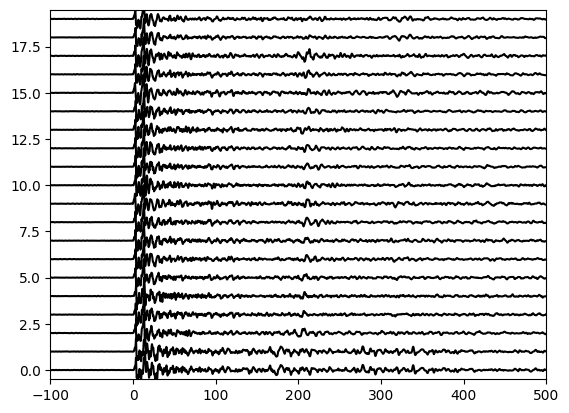

In [16]:
from mspasspy.graphics import SeismicPlotter
import matplotlib.pyplot as plt
from mspasspy.algorithms.basic import ExtractComponent
from mspasspy.algorithms.window import scale

plotter = SeismicPlotter()
plotter.change_style("wt")
site_matcher = ObjectIdMatcher(
    db, collection="site", attributes_to_load=["lat", "lon", "elev", "net", "sta"]
)
doc = db.source.find_one()
srcid = doc["_id"]
wfquery = {"source_id": srcid, "data_tag": "processed"}
n = db.wf_Seismogram.count_documents(wfquery)
print("Total number of seismogram objects for this event=", n)
cursor = db.wf_Seismogram.find(wfquery).sort("epicentral_distance")
cursor = cursor.limit(20)
ensemble = db.read_data(
    cursor, collection="wf_Seismogram", normalize=[site_matcher, source_matcher]
)
# plot to validate this is agrees with above
e = ExtractComponent(ensemble, 2)
e = scale(e)
for i in range(len(e.member)):
    e.member[i].ator(e.member[i]["Ptime"])
plotter.title = ""
plotter.plot(e)
plt.show()

Some of those look too similar.  Make sure we don't have duplicates.

In [17]:
print("net sta lat lon epicentral_distance")
for d in e.member:
    print(d["net"], d["sta"], d["site_lat"], d["site_lon"], d["epicentral_distance"])

net sta lat lon epicentral_distance
TA TOLK 68.6408 -149.5724 72.3876691751993
TA TOLK 68.6408 -149.5724 72.3876691751993
TA N59A 40.916801 -75.770302 83.19099478189707
TA E45A 46.3563 -85.177399 83.51091757782572
TA E44A 46.6199 -85.921402 83.6154286042604
TA F46A 45.773701 -84.758598 83.79106224036184
TA C40A 47.915401 -89.151398 83.87342879842222
TA F45A 45.683701 -85.515602 84.18696730260129
TA E43A 46.375801 -86.995399 84.25638874385253
TA C39A 47.817101 -90.128899 84.33056491596417
TA D41A 47.060501 -88.565697 84.3397583256051
TA F44A 45.973701 -86.4226 84.3400150358284
TA E42A 46.430099 -87.914001 84.58885135817034
TA M54A 41.5079 -79.664703 84.7242415715202
TA F43A 45.831299 -87.169403 84.76572563956555
TA C38A 47.717098 -91.273201 84.84680235124517
TA E41A 46.464298 -88.9636 84.9838499794824
TA O56A 40.268299 -78.566299 85.10508752951326
TA C37A 47.728298 -92.185303 85.176993290396
TA B35A 48.360298 -93.726097 85.20235453417214


Shows an issue for these tests that the test data set has stations from TA in Alaska (TOLK).   TOLK is the closest station to this event and has a very different waveform.  It also is a duplicate because it is a test location with two loc codes.   I'll leave the above there for the record and just change the query to exclude TOLK.  

Total number of seismogram objects for this event= 356


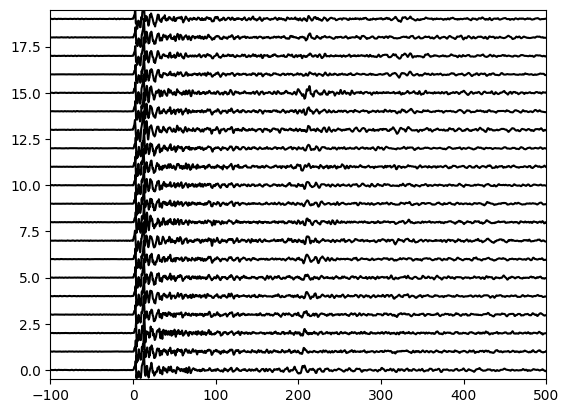

In [18]:
from mspasspy.graphics import SeismicPlotter
import matplotlib.pyplot as plt
from mspasspy.algorithms.basic import ExtractComponent
from mspasspy.algorithms.window import scale

plotter = SeismicPlotter()
plotter.change_style("wt")
site_matcher = ObjectIdMatcher(
    db, collection="site", attributes_to_load=["lat", "lon", "elev", "net", "sta"]
)
doc = db.source.find_one()
srcid = doc["_id"]
wfquery = {"source_id": srcid, "data_tag": "processed", "sta": {"$ne": "TOLK"}}
n = db.wf_Seismogram.count_documents(wfquery)
print("Total number of seismogram objects for this event=", n)
cursor = db.wf_Seismogram.find(wfquery).sort("epicentral_distance")
cursor = cursor.limit(20)
ensemble = db.read_data(
    cursor, collection="wf_Seismogram", normalize=[site_matcher, source_matcher]
)
# plot to validate this is agrees with above
e = ExtractComponent(ensemble, 2)
e = scale(e)
for i in range(len(e.member)):
    e.member[i].ator(e.member[i]["Ptime"])
plotter.title = ""
plotter.plot(e)
plt.show()

That fixed that problem.   Finally, save the ensemble data in a pickle file.  Note what we save is the TimeSeriesEnsemble extracted from the SeismogramEnsemble that has UTC timing and has not been scaled.

In [19]:
import pickle

fname = "MCXcor_testdata.pickle"
e = ExtractComponent(ensemble, 2)
fh = open(fname, "wb")
pickle.dump(e, fh)
fh.close()

Verify we can restore this and create the same graphic:

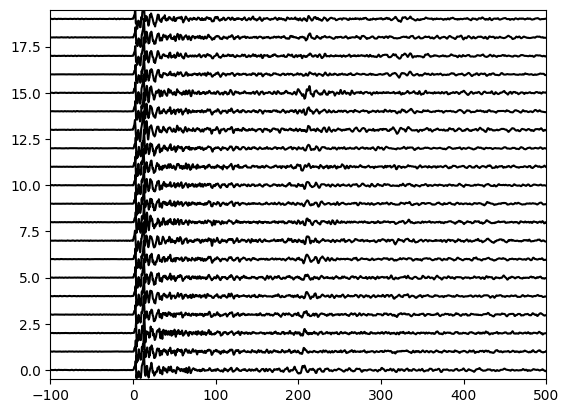

In [20]:
# verify we can read it back and get the same result
fh = open(fname, "rb")
e = pickle.load(fh)
e = scale(e)
for i in range(len(e.member)):
    e.member[i].ator(e.member[i]["Ptime"])
plotter.title = ""
plotter.plot(e)
plt.show()

For the context of this notebook we discard the database we created.   I don't throw away the miniseed data assuming anyone running this will clean that up with the unix shell.  

In [21]:
dbclient = msc.DBClient()
dbclient.drop_database("MCXcorTesting")